### Imports

In [1]:
# Libraries
import os
from importlib import reload
import keras
from keras import metrics
import tensorflow as tf
import matplotlib.pyplot as plt

# Scripts
from acml import data, runners, utils

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
!pip show keras

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(data)

<module 'acml.data' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\data.py'>

In [5]:
reload(runners)

<module 'acml.runners' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\runners.py'>

In [6]:
reload(utils)

<module 'acml.utils' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\utils.py'>

## `main`

In [7]:
# Silence information messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 


GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

### Load data

In [9]:
NUM_FOLDS = 5

In [10]:
# FULL DATASET:
# --- Takes _ minutes to run with data in csv --- #
# --- Takes 6 minutes to run with data in npz --- #

fold_dfs = data.get_fold_dfs_with_data(
    fold_definition_csv='data/deepship_5k_seg_3s.csv',
    new_path_to_root='data/deepship_ps_2_npz',
    npz=True,
    label_encodings={0:'Tanker', 1:'Cargo', 2:'Tug', 3:'Passengership'},
    n_folds=NUM_FOLDS
)
print('Successfully loaded folds with spectrograms.\n')

Successfully loaded folds with spectrograms.



In [11]:
# import cv2
# for df in fold_dfs:
#     df['spectrogram'] = df['spectrogram'].apply(lambda x: cv2.resize(x, (128, 128)))

In [12]:
fold_dfs[0]['spectrogram'][0].shape

(116, 100)

In [13]:
k_folds = data.get_splits_for_all_folds(
    fold_dfs, 
    conv_channel=True,
    verbose=False
)

del fold_dfs

In [14]:
# random_spec_pre = k_folds[2]['X_train'][28]
# print(random_spec_pre)

In [15]:
# k_folds = data.normalise_spectrograms(k_folds)

In [16]:
# random_spec_post = k_folds[2]['X_train'][28]
# print(random_spec_post)

In [17]:
# plt.figure(figsize=(8, 3))

# # INPUT
# plt.subplot(1, 2, 1)
# plt.imshow(random_spec_pre.squeeze(), cmap="viridis", aspect="auto")
# plt.title("Before Normalisation")
# plt.colorbar()

# # DENOISED OUTPUT
# plt.subplot(1, 2, 2)
# plt.imshow(random_spec_post.squeeze(), cmap="viridis", aspect="auto")
# plt.title("After Normalisation")
# plt.colorbar()

### Initialise model

In [18]:
from models import cnn_lstm

cnn_lstm_model = cnn_lstm.get_cnn_lstm(
    input_shape=k_folds[0]['X_train'].shape[1:],
    input_name='pspec',
    num_classes=4,
    verbose=True
)

cnn_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['acc']
)

Model: "cnn_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pspec (InputLayer)          [(None, 116, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 116, 100, 128)     3328      
                                                                 
 batch_normalization (BatchN  (None, 116, 100, 128)    512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 116, 100, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 50, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 50, 128)       409

### Configure model

In [19]:
# These are kwargs for Model.fit() and Model.evaluate() excluding x and y.
fit_kwargs = {
    'epochs': 1,
    'validation_split': 0.2,
    'batch_size': 8,
    'verbose': 1,
    'callbacks': [cnn_lstm.callback_early_stop(patience=3, restore_best_weights=True)]
}

eval_kwargs = {
    'batch_size': 8,
    'verbose': 1
}

### Run k-fold cross val

In [20]:
model, histories, evals, metrics = runners.k_fold_cross_validation(
    k_folds=k_folds,
    model=cnn_lstm_model,
    fit_xy=('X_train', 'y_train'),
    fit_kwargs=fit_kwargs,
    eval_xy=('X_test', 'y_test'),
    eval_kwargs=eval_kwargs,
    use_cpu=False
)

FOLD 1
142/142 [==============================] - 8s 50ms/step
FOLD 2
172/172 [==============================] - 7s 37ms/step
FOLD 3
167/167 [==============================] - 6s 38ms/step
FOLD 4
242/242 [==============================] - 9s 38ms/step
FOLD 5
182/182 [==============================] - 7s 40ms/step


In [21]:
# model.save('models\cnn_lstm_psd_2_10.keras')

### Calculate metrics

In [22]:
evals

[[0.8581299185752869, 0.6387295722961426],
 [0.6040597558021545, 0.7464532852172852],
 [0.4344039857387543, 0.828496515750885],
 [0.505760133266449, 0.7910950183868408],
 [0.985314667224884, 0.6822172403335571]]

In [23]:
loss, acc = utils.calculate_metrics(evals)
print(f"Average loss: {loss}")
print(f"Average accuracy: {acc}")

Average loss: 0.6775336921215057
Average accuracy: 0.7373983263969421


In [24]:
len(histories[0].history['acc'])

1

C:\Users\sonar\AppData\Local\Temp\ipykernel_6248\201228151.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


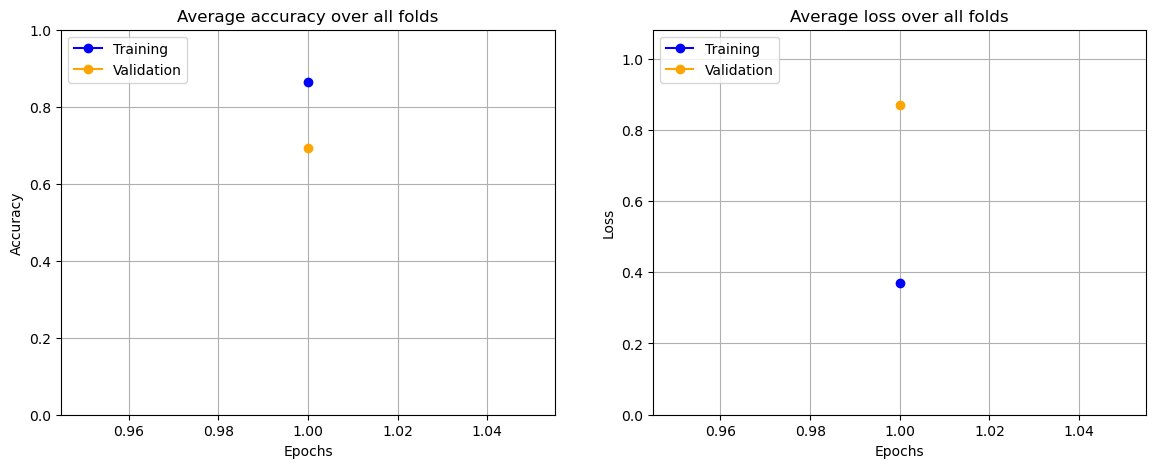

In [25]:
fig = utils.get_acc_loss_curves(histories, overlay=True)
fig.show()

In [26]:
# fig.savefig('models/img/cnn_lstm_psd_20.pdf')

In [27]:
print("Average Precision:", metrics["precision"])
print("Average Recall:", metrics["recall"])
print("Average F1 Score:", metrics["f1_score"])

Average Precision: 0.7627457740941451
Average Recall: 0.7374671873728232
Average F1 Score: 0.7383620972803105
